# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

# Read and clean data

Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [47]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


risk_free_rate_annualized = 0.05

df = pd.read_csv('stock data.csv', sep=';', decimal=',',thousands='.')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

#Daily returns

df = df.pct_change()

#annualization 
period = ((df.index.max() - df.index.min()).days)/365.25
total_trading_days = df.shape[0]
trading_days_pr_year = total_trading_days/period



#mean values
mean_c25_annualized = (1+df['c25'].mean())**trading_days_pr_year -1
mean_sp500_annualized = (1+df['sp500'].mean())**trading_days_pr_year -1
mean_dax_annualized = (1+df['dax'].mean())**trading_days_pr_year -1

return_vector = np.array([mean_c25_annualized, mean_sp500_annualized, mean_dax_annualized])



#covariance matrix
covariance_matrix = df.cov()*trading_days_pr_year

print(covariance_matrix)

#minimum variance portfolio 

#Calculating z-matrix

covariance_matrix_inverted = np.linalg.inv(covariance_matrix)
one_vector = np.ones((len(covariance_matrix),1))
z_vector_minvar = covariance_matrix_inverted.dot(one_vector)


#calculating weights for minimums variance portfolio
x_vector_minvar = (1/np.sum(z_vector_minvar))*z_vector_minvar

#expected return for minimum variance portfolio
exp_return_minvar = return_vector.dot(x_vector_minvar)

#Standard deviation for min variance portfolio
variance_minvar = np.transpose(x_vector_minvar).dot(covariance_matrix).dot(x_vector_minvar)

std_minvar = np.sqrt(variance_minvar)

#Efficient tangent portfolio
#Excess return 
excess_return_vector = return_vector - risk_free_rate_annualized

z_vector_efftan = covariance_matrix_inverted.dot(excess_return_vector)

#calculating weights for efficient tangent portfolio
x_vector_efftan = (1/np.sum(z_vector_efftan))*z_vector_efftan

#expected return for efficient tangent portfolio
exp_return_efftan = return_vector.dot(x_vector_efftan)

#Standard deviation for efficient tangent portfolio
variance_efftan = np.transpose(x_vector_efftan).dot(covariance_matrix).dot(x_vector_efftan)
std_efftan = np.sqrt(variance_efftan)


x_vector_minvar = np.transpose(x_vector_minvar)

Sharpe = ((exp_return_efftan - risk_free_rate_annualized)/std_efftan)
print(Sharpe)



            c25     sp500       dax
c25    0.029855  0.014422  0.021489
sp500  0.014422  0.036935  0.021911
dax    0.021489  0.021911  0.036753
0.5300453383674775


**Using the two mutual fund theorem we will create the efficient frontier**

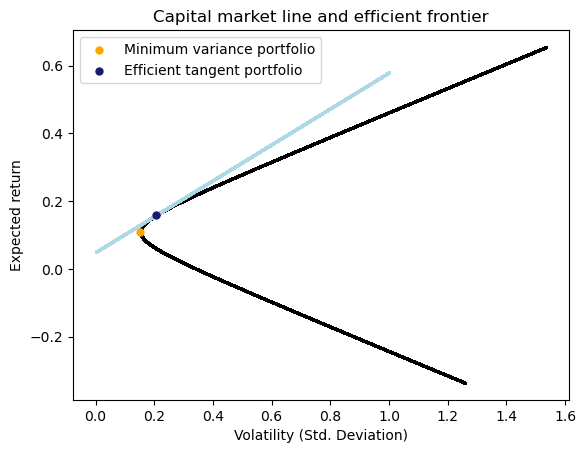

In [85]:
Two_mutual_fund_range = np.linspace(-10,10,100000)
return_list = []
volatility_list = []

for weight in Two_mutual_fund_range:
    minvar_weight = weight
    efftan_weight = 1 - minvar_weight
    portfolio_weight = minvar_weight*x_vector_minvar + efftan_weight*x_vector_efftan
    exp_return = portfolio_weight.dot(np.transpose(return_vector))
    var = portfolio_weight.dot(covariance_matrix).dot(np.transpose(portfolio_weight))
    std = np.sqrt(var)
    return_list.append(exp_return)
    volatility_list.append(std)

x_values = np.linspace(0,1,100000)
Capital_market_line = risk_free_rate_annualized+Sharpe*x_values


plt.scatter(volatility_list, return_list, s=1, color='black')
plt.scatter(x_values, Capital_market_line, color='lightblue', zorder=5, s=0.1)
plt.scatter(std_minvar, exp_return_minvar, color='orange', label='Minimum variance portfolio', zorder=5, s=25)
plt.scatter(std_efftan, exp_return_efftan, color='midnightblue', label='Efficient tangent portfolio', zorder=5, s=25)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected return')
plt.title('Capital market line and efficient frontier')

plt.legend()
plt.show()



In [90]:
from ipywidgets import interactive


def plot_efficient_frontier(risk_free_rate_annualized):
    excess_return_vector = return_vector - risk_free_rate_annualized
    z_vector_efftan = covariance_matrix_inverted.dot(excess_return_vector)
    x_vector_efftan = (1/np.sum(z_vector_efftan))*z_vector_efftan
    exp_return_efftan = return_vector.dot(x_vector_efftan)
    variance_efftan = np.transpose(x_vector_efftan).dot(covariance_matrix).dot(x_vector_efftan)
    std_efftan = np.sqrt(variance_efftan)
    Sharpe = (exp_return_efftan - risk_free_rate_annualized) / std_efftan
    
    # Plot code as before, using the updated 'risk_free_rate_annualized' and other calculations
    x_values = np.linspace(0,1,100000)
    Capital_market_line = risk_free_rate_annualized + Sharpe * x_values

    plt.figure(figsize=(12, 8))
    plt.scatter(volatility_list, return_list, s=1, color='black')
    plt.scatter(x_values, Capital_market_line, color='lightblue', zorder=5, s=0.1)
    plt.scatter(std_minvar, exp_return_minvar, color='orange', label='Minimum variance portfolio', zorder=5, s=25)
    plt.scatter(std_efftan, exp_return_efftan, color='midnightblue', label='Efficient tangent portfolio', zorder=5, s=25)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected return')
    plt.title('Capital market line and efficient frontier')
    plt.legend()
    plt.show()

# Create an interactive slider for 'risk_free_rate_annualized'
# Run this part in an IPython environment to see the interactive widget
interactive_plot = interactive(plot_efficient_frontier, risk_free_rate_annualized=(0, 0.2, 0.005))
output = interactive_plot.children[-1]
output.layout.height = '350px'  # You can set the height of the output plot area
interactive_plot

interactive(children=(FloatSlider(value=0.1, description='risk_free_rate_annualized', max=0.2, step=0.005), Ou…

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.